# An Empirical Evaluation of True Online TD(Lambda) by Harm van Seijen et. al and True Online Temporal-Difference Learning by Harm van Seijen et. al; Journal of Machine Learning Research 2016


In this IPython Notebook, I will walk through the various Function Approximation methods for estimating an optimal solution for the value functions V(s) i.e. On-policy prediction. Refer to the above two papers and the chapters: 9 and 12 from Sutton and Barto's Book. I have implemented the following algorithms:

1. Gradient Monte Carlo Algorithm for Approximating V
2. Semi-gradient TD(0) for estimating V_pi
3. TD(lambda)
4. True-online TD(lambda)
5. TD(0) for prediction. This result will act as the V_pi(s) to calculate RMSVE

We get introduced to lambda-return, eligibility traces and the dutch traces!



# Brief implementation details and metrics

1. The algorithms have been implemented for the GridWorld environment. The idea is to see the feasibility of the algorithms on environments which have not been explored in the paper or the text.
2. For function approximation, Fourier basis functions have been used as given. I have used 10 features for i=0 to i =9. A larger feature space tend to overfit.
3. The result from TD(0) for prediction act as the V_pi(s) to calculate RMSVE.
4. For the Root Mean Squared Value Error, I multiply the sqaured error by some time factor. In the equation it is denoted as d(s). Here, I define my own versin of d(s) where it denotes the number of times each state is visited. This d(s) is then multiplied by the squared error. This helps in setting the error proportionally for each state depending upon the frequency with which it occurs. d(s) has been normalized.


# Experiments || Code


In [257]:
#import the libraries

%matplotlib inline

import gym
import math
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import pylab
#import gym_maze

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib import plotting

from lib.envs.gridworld import GridworldEnv

matplotlib.style.use('ggplot')




# Sample GridWorld Environment

In [258]:
#Environment

print "Gridworld Environment of 16 states and 4 actions\n"

print "A sample environment is given below:\n"

env = GridworldEnv()

print "state is", env.reset()

print "next_state and reward are",env.step(2)[0],"and" ,env.step(2)[1], "\n"

print "A snapshot of the environment\n"

env.render()



Gridworld Environment of 16 states and 4 actions

A sample environment is given below:

state is 0
next_state and reward are 0 and 0.0 

A snapshot of the environment

x  o  o  o
o  o  o  o
o  o  o  o
o  o  o  T


# Choose an epsilon greedy policy with epsilon=0.1

In [259]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    We choose an epsilon greedy policy here.
    This is a cool helper function adapted from the WildML blog. 
    """
    
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

# Semi-gradient TD(0)

In [260]:
"""
semi_gradient_td_0
"""

def semi_gradient_td_0(env, num_episodes, alpha, discount_factor, epsilon):
    """
    Provide the values of the number of episodes, the learning rate alpha, discount factor, epsilon
    """
    #initialise V for all states
    #initialise states for all V
    V = np.zeros(env.nS)
    theta = np.zeros(10)
    time_spent_state = np.zeros(env.nS)
  
    

    # Plots
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #maps states to actions
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
     
    
    for i_episode in range(num_episodes):
        
        # reset state
        
        state = env.reset()

        
        state_scaled = float(state)/(env.nS-1)
        state_feature = np.zeros((10,))
        
        
        for i in range(len(state_feature)):
            
            state_feature[i] = math.cos(i*(math.pi)*state_scaled)
    
            
        
        # time step increment in the episode
        
        for t in itertools.count():
            
            for k in range(len(time_spent_state)):
                
                if state == k:
                    time_spent_state[k] += 1            
            
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_state, reward, done, _ = env.step(action)
            next_state_scaled = float(next_state)/(env.nS-1)
            next_state_feature = np.zeros((10,))
            
            for i in range(len(next_state_feature)):
                next_state_feature[i] = math.cos(i*(math.pi)*next_state_scaled)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            #update theta
            v_cap = np.dot(state_feature,theta)
            v_next_state = np.dot(next_state_feature,theta)
            grad_v_cap = state_feature
            
            theta = theta + alpha * (reward + discount_factor*v_next_state - v_cap) * grad_v_cap
            
                
            if done:
                break
                
            state = next_state
            
    for k in range(len(time_spent_state)):
        
        time_spent_state[k] = float(time_spent_state[k])/16
        
    #Calculate the V values for all the states
    
    for j in range(len(V)):
        v_state_scaled = float(j)/(env.nS-1)
        v_state_feature = np.zeros(10)
        
        for i in range(len(v_state_feature)):
            v_state_feature[i] = math.cos(i*(math.pi)*v_state_scaled)
            
        
        V[j] = np.dot(v_state_feature,theta)
          
            
    
    
    
    return V, time_spent_state

# Sample run for Semi-gradient TD(0)

In [261]:
"""
Let us now plot the various alpha values and the average return over the episodes.
We can choose the number of episodes, the learning rate alpha, the discount factor,
epsilon value for the soft greedy policy
"""

#initialise the variables or ask the user to input

n_episodes = 20

alpha = np.zeros([10])
alpha[0] = 0.01


eps = 0.1
gamma = 1

print "### Semi-gradient TD(0) for estimating V(pi)###\n"
print "### Gamma = 1 || eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(alpha)):
    
    
    V, time_spent = semi_gradient_td_0(env, n_episodes,alpha[i],gamma,eps)
    print "for alpha=", alpha[i], "Approximate Optimal Value of the states is\n", V
    
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.01

    


### Semi-gradient TD(0) for estimating V(pi)###

### Gamma = 1 || eps = 0.1 || number of episodes = 20 ###

for alpha= 0.01 Approximate Optimal Value of the states is
[-0.73945528 -1.49913994 -3.33018338 -3.69611447 -1.49606178 -0.77931377
 -2.57620664 -2.43643934 -1.3415238  -3.33958655 -4.68532646 -2.33739328
 -1.65098774 -3.3994622  -2.11446211 -0.15405999]
for alpha= 0.02 Approximate Optimal Value of the states is
[-14.54005407 -18.8679879  -24.54780228 -21.91060915 -15.1260301
 -14.02545872 -16.36210233 -14.65070393 -12.7808873  -16.73650491
 -20.00381713 -16.22061577 -11.19674886  -9.78512708  -8.87563052
  -7.93207617]
for alpha= 0.03 Approximate Optimal Value of the states is
[-0.76641248 -1.63203411 -2.69487979 -2.48173397 -2.28304511 -2.90736615
 -2.88525413 -1.97697187 -2.03133138 -3.12466394 -3.30912314 -2.5245962
 -2.44771543 -2.98424179 -2.89254776 -2.59098988]
for alpha= 0.04 Approximate Optimal Value of the states is
[-9.16643378 -7.55374852 -7.00362983 -8.8574624  -6.8

# Gradient Monte-Carlo ALgorithm

In [262]:
"""
gradient_mc
"""

def gradient_mc(env, num_episodes, alpha, discount_factor, epsilon,length_episode):
    """
    Provide the values of the number of episodes, the learning rate alpha, discount factor, epsilon
    """
    #initialise V for all states
    #initialise states for all V
    V = np.zeros(env.nS)
    theta = np.zeros(10)
    time_spent_state = np.zeros(env.nS)
  
    

    # Plots
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #maps states to actions
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
     
    
    for i_episode in range(num_episodes):
        #print "episode number=", (i_episode+1)
 
            
        episode = np.zeros((length_episode,2))
        #print episode.shape
        
        state = env.reset()

        for t in range(len(episode)):

            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            episode[t,0]= next_state
            episode[t,1]= reward

            if done:
                break
            state = next_state
        
        #print "sampled trajectory is", ,episode , "\n"
        
        state_scaled = float(state)/(env.nS-1)
        state_feature = np.zeros((10,))
        
        
        
        
        for i in range(len(state_feature)):
            
            state_feature[i] = math.cos(i*(math.pi)*state_scaled)
            
            
        G = 0

        
        # time step increment in the episode
        
        for t in range(len(episode)):
            G = gamma*G + episode[t,1]
            
            #time spent in states
            
            for k in range(len(time_spent_state)):
                if state == k:
                    time_spent_state[k] += 1
                    
                
            
            
            
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            #update theta
            v_cap = np.dot(state_feature,theta)
            grad_v_cap = state_feature
            
            theta = theta + alpha * (G - v_cap) * grad_v_cap
            
                
            if done:
                break
                
            state = next_state
            
    #calculate the final time factor
    
    for k in range(len(time_spent_state)):
        time_spent_state[k] = float(time_spent_state[k])/16
        
    
    
    
    #Calculate the V values for all the states
    
    
    for j in range(len(V)):
        v_state_scaled = float(j)/(env.nS-1)
        v_state_feature = np.zeros(10)
        
        for i in range(len(v_state_feature)):
            v_state_feature[i] = math.cos(i*(math.pi)*v_state_scaled)
            
        
        V[j] = np.dot(v_state_feature,theta)
        
          

    
    return V, time_spent_state

# Sample run for Gradient Monte-Carlo Algorithm


In [263]:
"""
Let us now plot the various alpha values and the average return over the episodes.
We can choose the number of episodes, the learning rate alpha, the discount factor,
epsilon value for the soft greedy policy
"""

#initialise the variables or ask the user to input

n_episodes = 10

alpha = np.zeros([10])
alpha[0] = 0.01


eps = 0.1
gamma = 1
length_episode = 10

print "### Gradient Monte-Carlo for estimating V(pi)###\n"
print "### Gamma = 1 || eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(alpha)):
    
    
    V, time_spent_state = gradient_mc(env, n_episodes,alpha[i],gamma,eps,length_episode)
    print "for alpha=", alpha[i], "Approximate Optimal Value of the states is\n", V
    
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.01

    

### Gradient Monte-Carlo for estimating V(pi)###

### Gamma = 1 || eps = 0.1 || number of episodes = 10 ###

for alpha= 0.01 Approximate Optimal Value of the states is
[-2.26166158 -4.76675218 -7.16906711 -4.53471503 -1.12636318 -0.79078968
 -1.16994965 -0.81436035 -0.91262298 -1.11127114 -0.84912195 -0.89978548
 -1.09523966 -0.89089564 -0.84649436 -0.98224036]
for alpha= 0.02 Approximate Optimal Value of the states is
[-2.01155586 -4.43963283 -7.6335375  -6.29804919 -2.31780625 -0.51856175
 -1.07512238 -1.33264968 -0.95865323 -1.0141306  -1.22173143 -1.06414785
 -0.99743351 -1.16695004 -1.12076278 -0.99340613]
for alpha= 0.03 Approximate Optimal Value of the states is
[-3.69293098 -5.15961274 -7.02081887 -5.85627998 -2.70487346 -0.88243791
 -0.98648069 -1.29083064 -1.13087543 -1.07774143 -1.18853668 -1.15265296
 -1.10391578 -1.16435953 -1.15712906 -1.11036053]
for alpha= 0.04 Approximate Optimal Value of the states is
[ -3.04583195  -7.08018532 -10.87554119  -6.58327879  -1.34024616
 

# Semi Gradient TD(lambda)

In [264]:
"""
semi_gradient_td_lambda
"""

def semi_gradient_td_lambda(env, num_episodes, alpha, discount_factor, epsilon,lambda_input):
    """
    Provide the values of the number of episodes, the learning rate alpha, discount factor, epsilon
    """
    #initialise V for all states
    #initialise states for all V
    V = np.zeros(env.nS)
    theta = np.zeros(10)
    time_spent_state = np.zeros(env.nS)
  
    

    # Plots
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #maps states to actions
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
     
    
    for i_episode in range(num_episodes):
        
        # reset state
        
        state = env.reset()

        
        state_scaled = float(state)/(env.nS-1)
        state_feature = np.zeros((10,))
        
        
        for i in range(len(state_feature)):
            
            state_feature[i] = math.cos(i*(math.pi)*state_scaled)
    
        
        etrace = np.zeros(10)
        
        # time step increment in the episode
        
        for t in itertools.count():
            
            for k in range(len(time_spent_state)):
                
                if state == k:
                    
                    time_spent_state[k] += 1
                    
                    
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_state, reward, done, _ = env.step(action)
            next_state_scaled = float(next_state)/(env.nS-1)
            next_state_feature = np.zeros((10,))
            
            for i in range(len(next_state_feature)):
                next_state_feature[i] = math.cos(i*(math.pi)*next_state_scaled)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # eligibility trace vectors and theta
            grad_v_cap = state_feature
            v_cap = np.dot(state_feature,theta)
            v_next_state = np.dot(next_state_feature,theta)
            
            
            etrace = discount_factor * lambda_input * etrace + grad_v_cap
            delta = reward + discount_factor*v_next_state - v_cap
            
            
            
            theta = theta + alpha * delta * etrace
            
                
            if done:
                break
                
            state = next_state
            
    for k in range(len(time_spent_state)):
        
        time_spent_state[k] = float(time_spent_state[k])/16
    
    #Calculate the V values for all the states
    
    for j in range(len(V)):
        v_state_scaled = float(j)/(env.nS-1)
        v_state_feature = np.zeros(10)
        
        for i in range(len(v_state_feature)):
            v_state_feature[i] = math.cos(i*(math.pi)*v_state_scaled)
            
        
        V[j] = np.dot(v_state_feature,theta)
          
            
    
    
    
    return V, time_spent_state

# Sample run for Semi-gradient TD(lambda) with eligibility traces

In [265]:
"""
Let us now plot the various alpha values and the average return over the episodes.
We can choose the number of episodes, the learning rate alpha, the discount factor,
epsilon value for the soft greedy policy
"""

#initialise the variables or ask the user to input

n_episodes = 20

alpha = np.zeros([10])
alpha[0] = 0.01
lambda_input = 0.3

eps = 0.1
gamma = 1

print "### Semi-gradient TD(lambda) for estimating V(pi)###\n"
print "### Gamma = 1 || eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(alpha)):
    
    
    V, time = semi_gradient_td_lambda(env, n_episodes,alpha[i],gamma,eps,lambda_input)
    print "for alpha=", alpha[i], "Approximate Optimal Value of the states is\n", V
    
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.01

### Semi-gradient TD(lambda) for estimating V(pi)###

### Gamma = 1 || eps = 0.1 || number of episodes = 20 ###

for alpha= 0.01 Approximate Optimal Value of the states is
[-1.80891303 -2.21407975 -2.9240696  -3.05695059 -2.75920707 -2.95772338
 -3.20384237 -2.34897466 -1.48822396 -2.39996561 -3.88561097 -3.81825731
 -2.81627338 -2.42962092 -2.55056741 -2.6133581 ]
for alpha= 0.02 Approximate Optimal Value of the states is
[-11.28257197 -10.21331895  -8.67600057  -7.1856144   -4.99595283
  -4.84093588  -6.21546551  -4.32609436  -2.62404538  -6.96010781
 -10.32574739  -6.26868412  -3.3108181   -7.31865101 -11.61102843
 -12.5738753 ]
for alpha= 0.03 Approximate Optimal Value of the states is
[-7.33401064 -7.38595285 -5.74667675 -2.27264855 -0.93753915 -2.29237672
 -2.83231785 -2.30822354 -2.70446344 -3.11977319 -2.45751438 -2.15364377
 -2.70843248 -2.67600239 -1.77138145 -1.23341965]
for alpha= 0.04 Approximate Optimal Value of the states is
[-10.77668322 -10.20084709 -11.11718805 -11.73

# TD(0) prediction for V_pi(s)

In [266]:
"""
td_0_v_pi
"""

def td_0_v_pi(env, num_episodes, alpha, discount_factor, epsilon):
    
    """
    Provide the values of the number of episodes, the learning rate alpha, discount factor, epsilon
    """
    #initialise V for all states
    V = np.zeros(env.nS)
    
  
    

    # Plots
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #maps states to actions
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
     
    
    for i_episode in range(num_episodes):
        
        # reset state
        
        state = env.reset()

        
        
        # time step increment in the episode
        
        for t in itertools.count():
            
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_state, reward, done, _ = env.step(action)
   
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            V[state] = V[state] + alpha * (reward + discount_factor*V[next_state] - V[state])
            
            
                
            if done:
                break
                
            state = next_state
    
    #Calculate the V values for all the states
    
    
    
    return V

# Sample run for TD(0) prediction for V_pi(s)

In [267]:
"""
Let us now plot the various alpha values and the average return over the episodes.
We can choose the number of episodes, the learning rate alpha, the discount factor,
epsilon value for the soft greedy policy
"""

#initialise the variables or ask the user to input

n_episodes = 5000

alpha = np.zeros([10])

avg_reward_q = np.zeros([10])

eps = 0.1
gamma = 1

V_pi = td_0_v_pi(env, n_episodes,0.7,gamma,eps)
print "TD(0) prediction for V_pi(s)\n",V_pi

    


TD(0) prediction for V_pi(s)
[   0.          -12.48691952  -89.24051246 -114.65676649   -1.
  -42.88482705  -61.10100482 -129.96864568   -2.00051038  -37.90887206
  -79.87427972 -150.2801432    -3.0158737   -72.84291171  -88.63116694
    0.        ]


# True Online TD(lambda) with eligibility traces

In [268]:
"""
true_online_td_lambda
"""

def true_online_td_lambda(env, num_episodes, alpha, discount_factor, epsilon,lambda_input):
    """
    Provide the values of the number of episodes, the learning rate alpha, discount factor, epsilon
    """
    #initialise V for all states
    #initialise states for all V
    V = np.zeros(env.nS)
    theta = np.zeros(10)
    time_spent_state = np.zeros(env.nS)
  
    

    # Plots
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #maps states to actions
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
     
    
    for i_episode in range(num_episodes):
        
        # reset state
        
        state = env.reset()

        
        state_scaled = float(state)/(env.nS-1)
        state_feature = np.zeros((10,))
        
        
        for i in range(len(state_feature)):
            
            state_feature[i] = math.cos(i*(math.pi)*state_scaled)
    
        
        etrace = np.zeros(10)
        v_old = 0
        
        # time step increment in the episode
        
        for t in itertools.count():
            
            for k in range(len(time_spent_state)):
                
                if state == k:
                    
                    time_spent_state[k] += 1
                    
                    
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_state, reward, done, _ = env.step(action)
            next_state_scaled = float(next_state)/(env.nS-1)
            next_state_feature = np.zeros((10,))
            
            for i in range(len(next_state_feature)):
                next_state_feature[i] = math.cos(i*(math.pi)*next_state_scaled)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # eligibility trace vectors and theta
            
            v = np.dot(state_feature,theta)
            v_cap = np.dot(next_state_feature,theta)
            grad_v = state_feature
            
            etrace = discount_factor * lambda_input * etrace + (1- alpha * discount_factor * lambda_input* np.dot(etrace,grad_v)) * state_feature
            delta = reward + discount_factor*v_cap - v
            
            
            
            theta = theta + alpha * (delta + v - v_old)* etrace - alpha * (v - v_old) * state_feature
            
            v_old = v_cap
            state_feature = next_state_feature
            
                
            if done:
                next_state_feature = np.zeros(10)
                break
                
            state = next_state
            
    for k in range(len(time_spent_state)):
        
        time_spent_state[k] = float(time_spent_state[k])/16
        
        
    #Calculate the V values for all the states

    
    #Calculate the V values for all the states
    
    for j in range(len(V)):
        v_state_scaled = float(j)/(env.nS-1)
        v_state_feature = np.zeros(10)
        
        for i in range(len(v_state_feature)):
            v_state_feature[i] = math.cos(i*(math.pi)*v_state_scaled)
            
        
        V[j] = np.dot(v_state_feature,theta)


    
    return V, time_spent_state

# Sample run for True Online TD(lambda) with Dutch Traces

In [269]:
"""
Let us now plot the various alpha values and the average return over the episodes.
We can choose the number of episodes, the learning rate alpha, the discount factor,
epsilon value for the soft greedy policy
"""

#initialise the variables or ask the user to input

n_episodes = 10

alpha = np.zeros([10])
alpha[0] = 0.001
lambda_input = 0.05

eps = 0.1
gamma = 1

print "### True-online TD(lambda) for estimating V(pi)###\n"
print "### Gamma = 1 || eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(alpha)):
    
    
    V,time = true_online_td_lambda(env, n_episodes,alpha[i],gamma,eps,lambda_input)
    print "for alpha=", alpha[i], "Approximate Optimal Value of the states is\n", V
    
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.001

### True-online TD(lambda) for estimating V(pi)###

### Gamma = 1 || eps = 0.1 || number of episodes = 10 ###

for alpha= 0.001 Approximate Optimal Value of the states is
[-0.95766151 -2.77142328 -5.79189143 -5.72684299 -2.46412822 -0.44000149
 -1.26833863 -1.75037733 -0.80723751 -0.66455862 -1.21601377 -0.91833311
 -0.66214545 -1.09540669 -1.01009541 -0.66347536]
for alpha= 0.002 Approximate Optimal Value of the states is
[-3.32754489 -4.79319092 -5.59427311 -3.01489141 -1.02373223 -1.549993
 -1.68086028 -0.92798452 -0.95450191 -1.10154634 -0.77295088 -0.87847726
 -1.08397301 -0.81664085 -0.83897862 -1.06063632]
for alpha= 0.003 Approximate Optimal Value of the states is
[-1.54393918 -3.97274218 -7.80015476 -7.36460069 -3.06071289 -0.6996152
 -1.93943329 -2.60769144 -1.37646569 -0.99926606 -1.5580129  -1.28360961
 -1.01189267 -1.45855997 -1.37812673 -1.02136675]
for alpha= 0.004 Approximate Optimal Value of the states is
[ -5.74484813 -11.8505022  -17.4350773  -10.81615511  -3.5073733

# """"RESULTS""""

## Calculate the Root Mean Squared Error for Value functions across all states ||| The plots show the RMSVE for both with the time factor(d(s)) and without it.

# "RMSVE v/s Alpha for various methods to estimate V(pi)"

In [270]:
n_episodes = 40

alpha = np.zeros([10])
alpha[0] = 0.001
rmsve_td_0_semi_gradient = np.zeros([10])
rmsve_td_lambda = np.zeros([10])
rmsve_mc_gradient = np.zeros([10])
rmsve_td_lambda_true_online = np.zeros([10])
rmsve_mc_gradient_time = np.zeros([10])
rmsve_td_0_semi_gradient_time = np.zeros([10])
rmsve_td_lambda_true_online_time = np.zeros([10])
rmsve_td_lambda_time = np.zeros([10])


eps = 0.1
gamma = 1
length_episode = 15
lambda_input = 0.05

print "### Various algorithms for estimating V(pi) using Function Approximation for TD Learning###\n"
print "### Gamma = 1 || eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(alpha)):
    
    
    V, time_spent_state_1= semi_gradient_td_0(env, n_episodes,alpha[i],gamma,eps)
    V_mc, time_spent_state_2 = gradient_mc(env, n_episodes,alpha[i],gamma,eps,length_episode)
    V_td_lambda, time_spent_state_3 = semi_gradient_td_lambda(env, n_episodes,alpha[i],gamma,eps,lambda_input)
    V_td_lambda_true_online, time_spent_state_4 = true_online_td_lambda(env, n_episodes,alpha[i],gamma,eps,lambda_input)
    
    rmsve_td_lambda_true_online[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_td_lambda_true_online))))
    rmsve_td_0_semi_gradient[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V))))
    rmsve_mc_gradient[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_mc))))
    rmsve_td_lambda[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_td_lambda))))

    
    #with time factor
    rmsve_td_0_semi_gradient_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V)),time_spent_state_1)))
    rmsve_mc_gradient_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_mc)),time_spent_state_2)))
    rmsve_td_lambda_true_online_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_td_lambda_true_online)),time_spent_state_4)))
    rmsve_td_lambda_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_td_lambda)),time_spent_state_3)))
    
    #print "The RMSVE for alpha=", alpha[i], "is", rmsve_td_0_semi_gradient[i],"Semi-gradient TD(0)", "\n"
    #print "The RMSVE for alpha=", alpha[i], "is", rmsve_mc_gradient[i], "Gradient Monte-Carlo", "\n"
    #print "The RMSVE for alpha=", alpha[i], "is", rmsve_td_lambda[i],"Semi-gradient TD(lambda)", "\n"
    
    #print "The RMSVE for alpha=", alpha[i], "is", rmsve_mc_gradient_time[i], "Gradient Monte-Carlo with time factor", "\n"
    
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.001

    


### Various algorithms for estimating V(pi) using Function Approximation for TD Learning###

### Gamma = 1 || eps = 0.1 || number of episodes = 40 ###



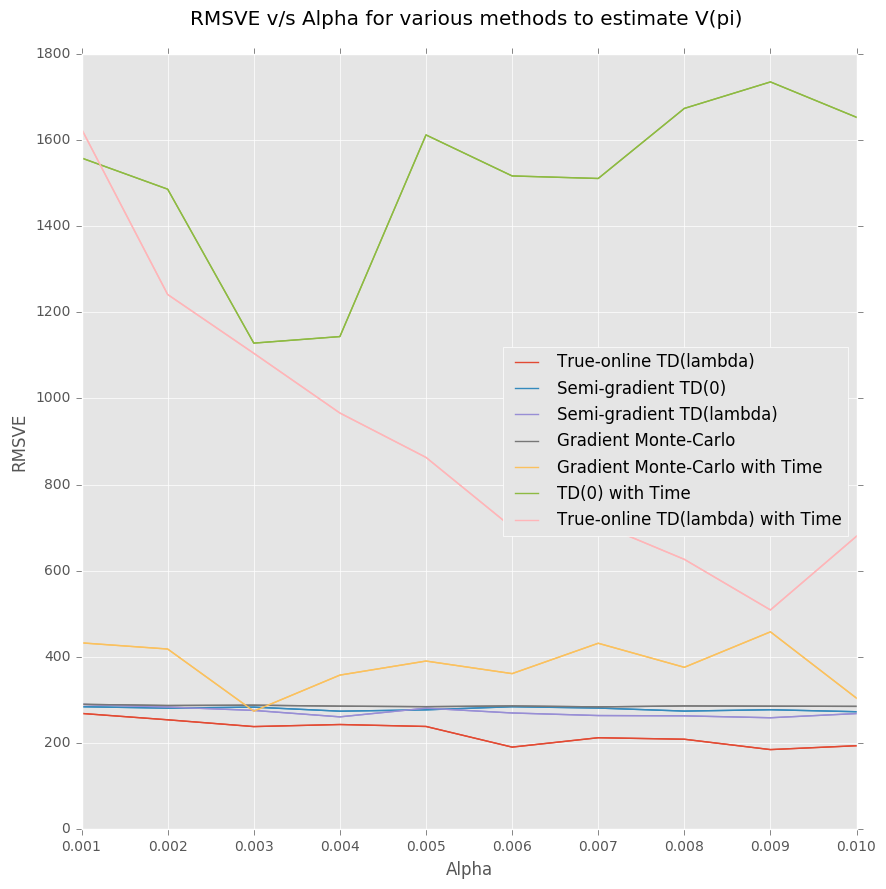

In [271]:
# Plot the above calculated statistics

plt.figure(figsize=(10,10))

plt.plot(alpha, rmsve_td_lambda_true_online)
plt.plot(alpha, rmsve_td_0_semi_gradient)
plt.plot(alpha, rmsve_td_lambda)
plt.plot(alpha, rmsve_mc_gradient)

plt.plot(alpha, rmsve_mc_gradient_time)
plt.plot(alpha, rmsve_td_0_semi_gradient_time)
plt.plot(alpha, rmsve_td_lambda_true_online_time)
#plt.plot(alpha, rmsve_td_lambda_time)

plt.title("RMSVE v/s Alpha for various methods to estimate V(pi) \n")
plt.xlabel('Alpha')
plt.ylabel('RMSVE')

plt.plot(alpha, rmsve_td_lambda_true_online, label='True-online TD(lambda)')
plt.plot(alpha, rmsve_td_0_semi_gradient, label='Semi-gradient TD(0)')
plt.plot(alpha, rmsve_td_lambda, label='Semi-gradient TD(lambda)')
plt.plot(alpha, rmsve_mc_gradient, label='Gradient Monte-Carlo')

plt.plot(alpha, rmsve_mc_gradient_time, label='Gradient Monte-Carlo with Time')
plt.plot(alpha, rmsve_td_0_semi_gradient_time, label='TD(0) with Time')
plt.plot(alpha, rmsve_td_lambda_true_online_time, label='True-online TD(lambda) with Time')
#plt.plot(alpha, rmsve_td_lambda_time, label='TD(lambda) with Time')

plt.legend(loc="best")

plt.show()

# RMSVE v/s Lambda for various methods to estimate V(pi)

In [272]:
###### TD(lambda) and True-online TD(lambda)



n_episodes = 40

lambda_input = np.zeros([10])
lambda_input[0] = 0.0
rmsve_td_lambda = np.zeros([10])
rmsve_td_lambda_true_online = np.zeros([10])

rmsve_td_lambda_true_online_time = np.zeros([10])
rmsve_td_lambda_time = np.zeros([10])

eps = 0.1
gamma = 1
length_episode = 10

alpha = 0.01

print "### Various algorithms for estimating V(pi) using Function Approximation for TD Learning###\n"
print "### Gamma = 1 || eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(lambda_input)):
    
    
    V_td_lambda,time_spent_state_3 = semi_gradient_td_lambda(env, n_episodes,alpha,gamma,eps,lambda_input[i])
    V_td_lambda_true_online,time_spent_state_4 = true_online_td_lambda(env, n_episodes,alpha,gamma,eps,lambda_input[i])
    
    rmsve_td_lambda[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_td_lambda))))
    rmsve_td_lambda_true_online[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_td_lambda_true_online))))
    
    rmsve_td_lambda_true_online_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_td_lambda_true_online)),time_spent_state_4)))
    rmsve_td_lambda_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_td_lambda)),time_spent_state_3)))
    
    
    #print "The RMSVE for lambda=", lambda_input[i], "is", rmsve_td_lambda[i],"for Semi-gradient TD(lambda)", "\n"
    
    if i<9:
        
        lambda_input[i+1] = lambda_input[i] + 0.01

    


### Various algorithms for estimating V(pi) using Function Approximation for TD Learning###

### Gamma = 1 || eps = 0.1 || number of episodes = 40 ###



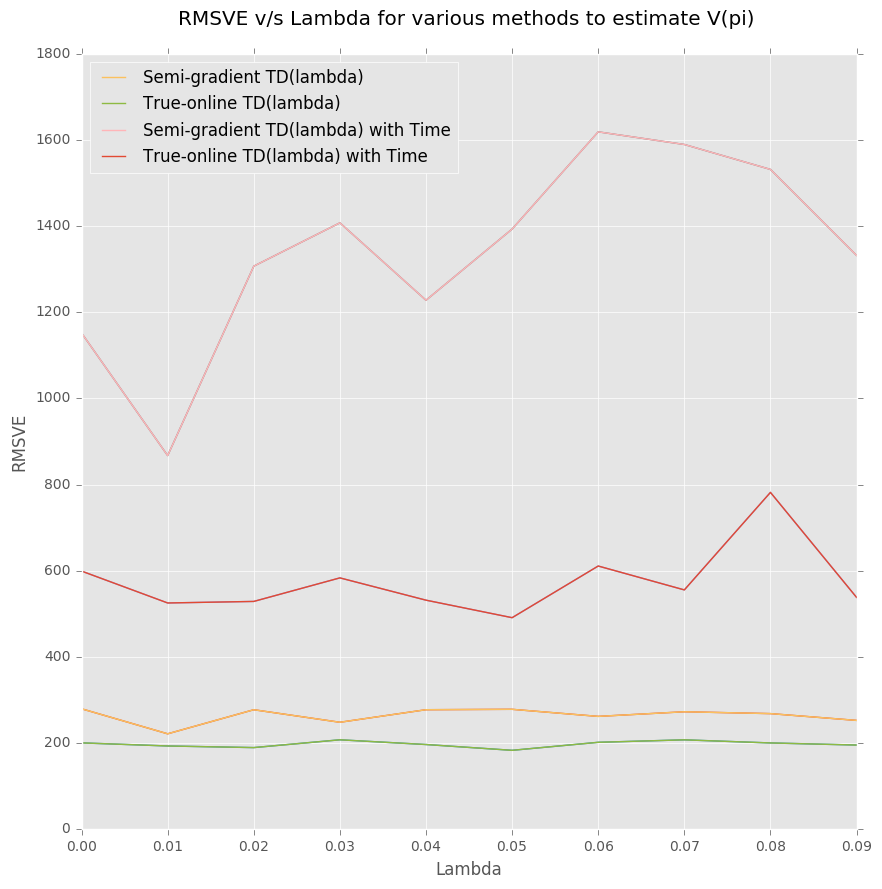

In [273]:
# Plot the above calculated statistics

plt.figure(figsize=(10,10))
    
plt.plot(lambda_input, rmsve_td_lambda)
plt.plot(lambda_input, rmsve_td_lambda_true_online)
plt.plot(lambda_input, rmsve_td_lambda_true_online_time)
plt.plot(lambda_input, rmsve_td_lambda_time)

plt.title("RMSVE v/s Lambda for various methods to estimate V(pi) \n")
plt.xlabel('Lambda')
plt.ylabel('RMSVE')

plt.plot(lambda_input, rmsve_td_lambda, label='Semi-gradient TD(lambda)')
plt.plot(lambda_input, rmsve_td_lambda_true_online, label='True-online TD(lambda)')

plt.plot(lambda_input, rmsve_td_lambda_time, label='Semi-gradient TD(lambda) with Time')
plt.plot(lambda_input, rmsve_td_lambda_true_online_time, label='True-online TD(lambda) with Time')


plt.legend(loc="best")

plt.show()

# Results and Intuition:

1. The TD(0) method's solution is used to calculate the RMSVE.
2. The error is weighted by the amount of time spent in the state. This helps in giving a true estimate how of eahc state contibutes to the error of the Value function. This is advisable because it helps to identify which states are the culprits!
3. For the given environment, one has to choose the alpha and lambda values correctly. A good estimate for V(s) is obtained when alpha=0.01 and lambda between 0.04 and 0.05. Also, note that the number of episodes to obtain the RMSVE is 40
4. From the second graph, we can see that the True-online TD(lambda) method ourperforms the Semi-gradient TD(lmabda) by a margin of error of around 70. Also, for the time weighted RMSVE we again see that the True-online TD(lambda) method ourperforms the Semi-gradient TD(lmabda). This time by a margin of error of around 800! This result can be attributed to a good stability with respect to the step-size. Also, in the case of True-online there is no overhead of deciding between accumulate and replace TD.
5. In graph one, we can see that True-online TD(lambda) performs the best and the Semi-gradient TD(0) performs the worst. Interestingly, Semi-gradient TD(lambda) gives results close to True-online TD(lambda). We can see the effect of the elgibility trace vector in action!
6. Thus the backward view of the True-online method and the Dutch Trace vector improves the performance over the other methods. The eligibility(dutch) trace keeps track of which components of the weight vector have contributed, positively or negatively, to recent state valuations.
 


# Future possibilities:
1. Try out a non-linear function approximator. Perhaps, a simple feedforward neural network for FA
2. Try out various basis functions for Linear FA.
3. Use a more sophisticated version of the RMSVE.
4. Implement the above algorithms for comparions for control.
5. Give a more comprehensive analysis of alphas and lambda values with a convergence guarantee.
6. Try out more environments.


# The End